In [1]:
%matplotlib inline

# Libraries

In [2]:
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process
import datetime

In [3]:
plt.style.use('fivethirtyeight')
palette = sns.palettes.color_palette()

# Load data

In [4]:
data_agg = pd.read_csv('../data/data_agg.csv', 
                       index_col=0)

In [5]:
data_agg.head()

,hour,N_clicks,N_impressions,CTR,datetime,date
0,14102100,20792,119006,0.174714,2014-10-21 00:00:00,2014-10-21
1,14102101,23873,137442,0.173695,2014-10-21 01:00:00,2014-10-21
2,14102102,31265,207471,0.150696,2014-10-21 02:00:00,2014-10-21
3,14102103,32830,193355,0.169791,2014-10-21 03:00:00,2014-10-21
4,14102104,40026,264711,0.151206,2014-10-21 04:00:00,2014-10-21


In [15]:
data_agg.datetime = pd.to_datetime(data_agg.datetime)

# Plot CTR vs time

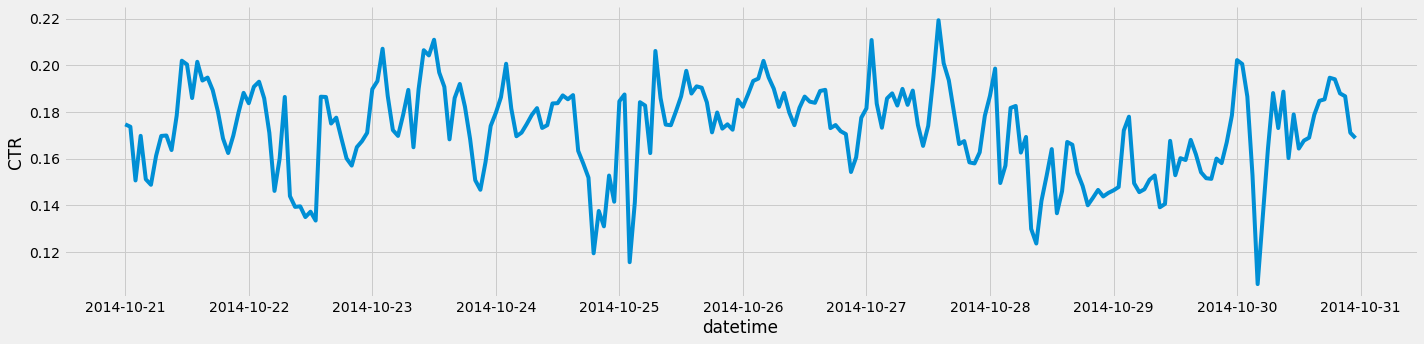

In [16]:
_ = sns.relplot(x="datetime", 
            y="CTR", 
            kind="line", 
            data=data_agg, aspect = 4)


# Find outliers

## Moving average approach

Plot

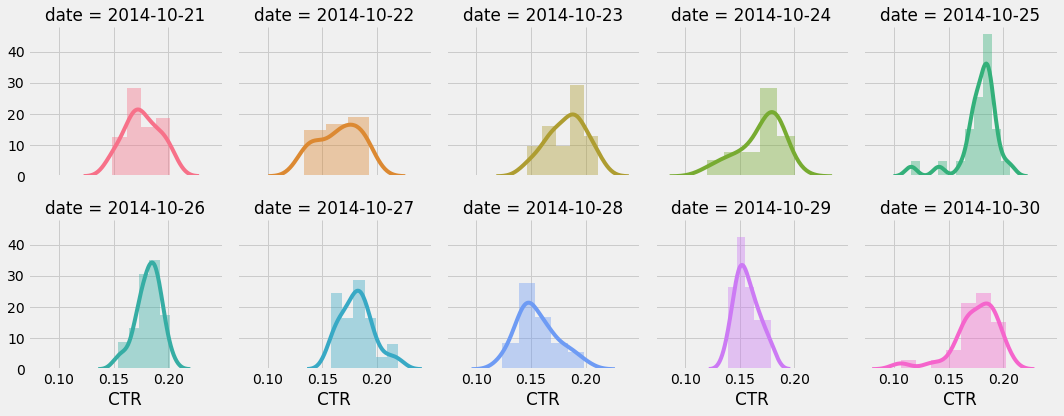

In [17]:
grid = sns.FacetGrid(data_agg, 
                     col="date", 
                     hue="date",
                     col_wrap=5, 
                     height=3)

_ = grid.map(sns.distplot, "CTR")

Calculate mean and std

In [18]:
n_stds = 1.5

In [19]:
data_agg['CTR_mean'] = data_agg.groupby('date').CTR.transform('mean')
data_agg['CTR_std'] = data_agg.groupby('date').CTR.transform('std')

data_agg['outlier'] = (data_agg.CTR < data_agg.CTR_mean - n_stds*data_agg.CTR_std) | (data_agg.CTR > data_agg.CTR_mean + n_stds*data_agg.CTR_std)

Plot with outliers

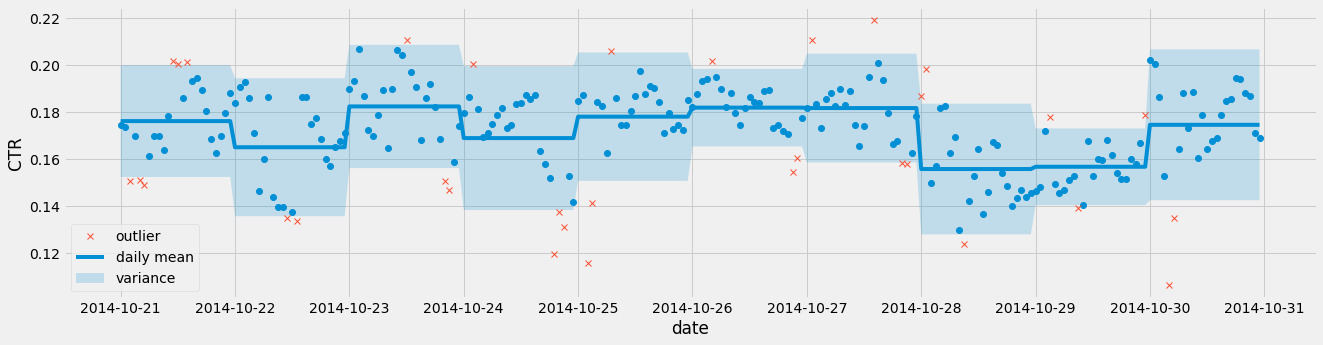

In [20]:
plt.figure(figsize=(20, 5))
plt.plot_date(data_agg[data_agg['outlier'] == False].datetime, 
              data_agg[data_agg['outlier'] == False].CTR)
plt.plot_date(data_agg[data_agg['outlier'] == True].datetime, 
              data_agg[data_agg['outlier'] == True].CTR,
             label = 'outlier',
             marker = 'x')
plt.plot_date(data_agg.datetime,
             data_agg.CTR_mean,
            '-',
            color = palette[0],
             label = 'daily mean')
plt.fill_between(data_agg.datetime,
                data_agg.CTR_mean - data_agg.CTR_std*n_stds,
                data_agg.CTR_mean + data_agg.CTR_std*n_stds,
                alpha = 0.2,
                label = 'variance')
plt.xlabel('date')
plt.ylabel('CTR')
_ = plt.legend()

## Gaussian process regression

In [21]:
#Kernel
kernel = 1**2*sklearn.gaussian_process.kernels.RBF(length_scale=5000, 
                                                  length_scale_bounds=(15000, 20000)
                                                  ) + 0*sklearn.gaussian_process.kernels.WhiteKernel(10)

#Gaussian process regressor
gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel)

In [22]:
#Fit and predict
x_train = data_agg['datetime'].apply(lambda x: x.timestamp())[:, None]
y_train = (data_agg.CTR - data_agg.CTR.mean())[:, None]
x_date = pd.date_range(data_agg.datetime.min(), 
                       data_agg.datetime.max(), 
                       periods=1000).to_pydatetime()
vfunc = np.vectorize(lambda x: x.timestamp())
x_ = vfunc(x_date)[:, None]

fit = gpr.fit(x_train, y_train)
y_pred, sigma = fit.predict(x_, return_std=True)
y_samples = fit.sample_y(x_, 10)

/home/tatyana/anaconda3/envs/pymc_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


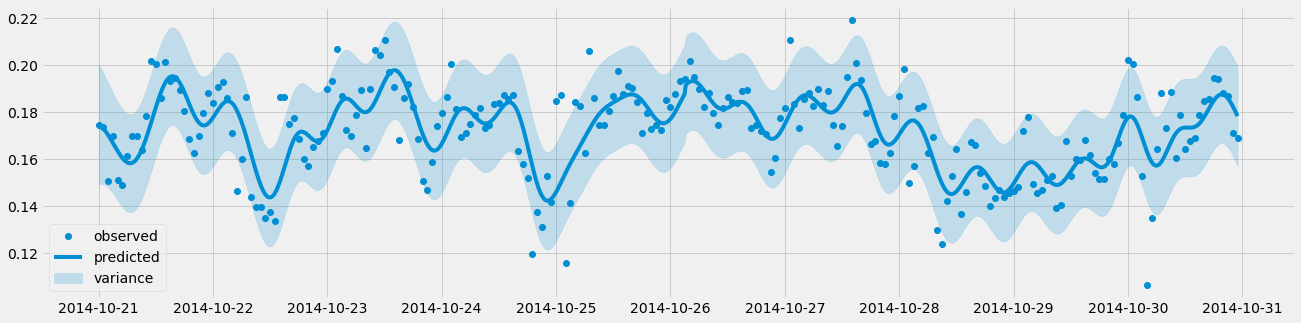

In [23]:
plt.figure(figsize=(20, 5))
plt.plot_date(data_agg.datetime, y_train + data_agg.CTR.mean(), 'o', label = 'observed')
plt.plot_date(x_date, y_pred + data_agg.CTR.mean(), '-', label = 'predicted', color = palette[0])
plt.fill_between(x_date, 
                y1 = y_pred.squeeze() + data_agg.CTR.mean() + n_stds*sigma, 
                y2 = y_pred.squeeze() + data_agg.CTR.mean() - n_stds*sigma, 
                alpha = 0.2, 
                color = palette[0], 
                label = 'variance')
_ = plt.legend()